# Pretrained CNN

This notebook is a testbench for different parameters of a convolutional neural network where the convolutional layers are that of ResNet101. Different hyperparameters are tested and plotted.


## Enabling and testing the GPU

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from keras import layers, models, optimizers, datasets, regularizers
import time
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


## Network generating function

Test function to run different topologies and plot their test and train performances. Maintains best hyperparameters found in the previous tests by default

In [37]:
def tryTopologies(resnet, depths, widths, train_img, train_lbl, test_img,
                  test_lbl, learning_rate=0.00057, training_epochs=5,
                  batch_size=[16], momentum = 0.9, l2_norm=0):
  %matplotlib inline
  import matplotlib.pyplot as plt
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True)
  fig.set_figheight(15)
  fig.set_figwidth(15)

  for depth in depths:
    for width in widths:
      for batch in batch_size:
        performanceData = fitWithHyperParams(resnet, depth, width, train_img,
                                           train_lbl, test_img, test_lbl,
                                           learning_rate, momentum,
                                           training_epochs, batch,
                                           l2_norm=l2_norm)
      
        t = np.cumsum(performanceData[0])
        # plot the data on the same subplot
        ax1.plot(t - t[0], 100 * performanceData[1], label=f"D: {depth} W: {width}",
                  marker='o', linestyle='-')
        ax2.plot(t - t[0], 100 * performanceData[3], label=f"D: {depth} W: {width}",
                  marker='o', linestyle='-')
        ax3.plot(t - t[0], performanceData[2], label=f"D: {depth} W: {width}",
                  marker='o', linestyle='-')
        ax4.plot(t - t[0], performanceData[4], label=f"D: {depth} W: {width}",
                  marker='o', linestyle='-')
    
  ax1.set_title('Training accuracy')
  ax2.set_title('Test accuracy')
  ax3.set_title('Training loss')
  ax4.set_title('Test loss')

  ax1.set_xlabel('Time (s)')
  ax1.set_ylabel('Training accuracy (%)')
  ax2.set_xlabel('Time (s)')
  ax2.set_ylabel('Testing accuracy (%)')
  ax3.set_xlabel('Time (s)')
  ax3.set_ylabel('Training loss')
  ax4.set_xlabel('Time (s)')
  ax4.set_ylabel('Testing loss')
  ax3.set_ylim(0, 3)
  ax4.set_ylim(0, 3)

  ax1.legend()
  ax2.legend()
  ax3.legend()
  ax4.legend()

  ax1.grid()
  ax2.grid()
  ax3.grid()
  ax4.grid()
  plt.show()

# Plotter

Logs the runtime information per epoch and can compare multiple different configurations by plotting them together.

In [33]:
def fitWithHyperParams(conv_pretrained, hidden_layers, neuron_count, train_images, train_labels, test_images, test_labels, 
                       learning_rate, momentum, epochs, batch_size, l2_norm=0):
    # Construct the model as described by the lab handout and hyperparameters
    for layer in conv_pretrained.layers:
        layer.trainable = False
    # Define a new Sequential instance and add the pre-trained ResNet model as its first layer
    model = keras.Sequential()
    model.add(conv_pretrained)

    # Add specified number of fully-connected hidden layers
    model.add(keras.layers.Flatten())
    for i in range(0, hidden_layers):
      if(l2_norm):
        model.add(keras.layers.Dense(neuron_count, activation='relu',
                                     kernel_regularizer=keras.regularizers.L2(l2_norm)))
      else:
        model.add(keras.layers.Dense(neuron_count, activation='relu'))

    # Add the output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    # Optimize with gradient descent
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    # Finally, compile the model
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])

    training_times = []
    training_accuracies = []
    training_losses = []
    test_accuracies = []
    test_losses = []

    for i in range(epochs):
        start_time = time.time()
        performance = model.fit(train_images, train_labels, epochs=1, batch_size=batch_size,
                              validation_data=(test_images, test_labels))
        end_time = time.time()
        training_time = end_time - start_time
        training_times.append(training_time)

        training_accuracies.append(performance.history['accuracy'][0])
        training_losses.append(performance.history['loss'][0])
        test_accuracies.append(performance.history['val_accuracy'][0])
        test_losses.append(performance.history['val_loss'][0])

    return [np.array(training_times), np.array(training_accuracies),
            np.array(training_losses), np.array(test_accuracies), np.array(test_losses)]

# Initialization and loading the dataset

Constructs the input layers that will be common to all tested configurations.

3125/3125 [==============================] - 71s 23ms/step - loss: 0.8320 - accuracy: 0.7061 - val_loss: 1.1791 - val_accuracy: 0.6180


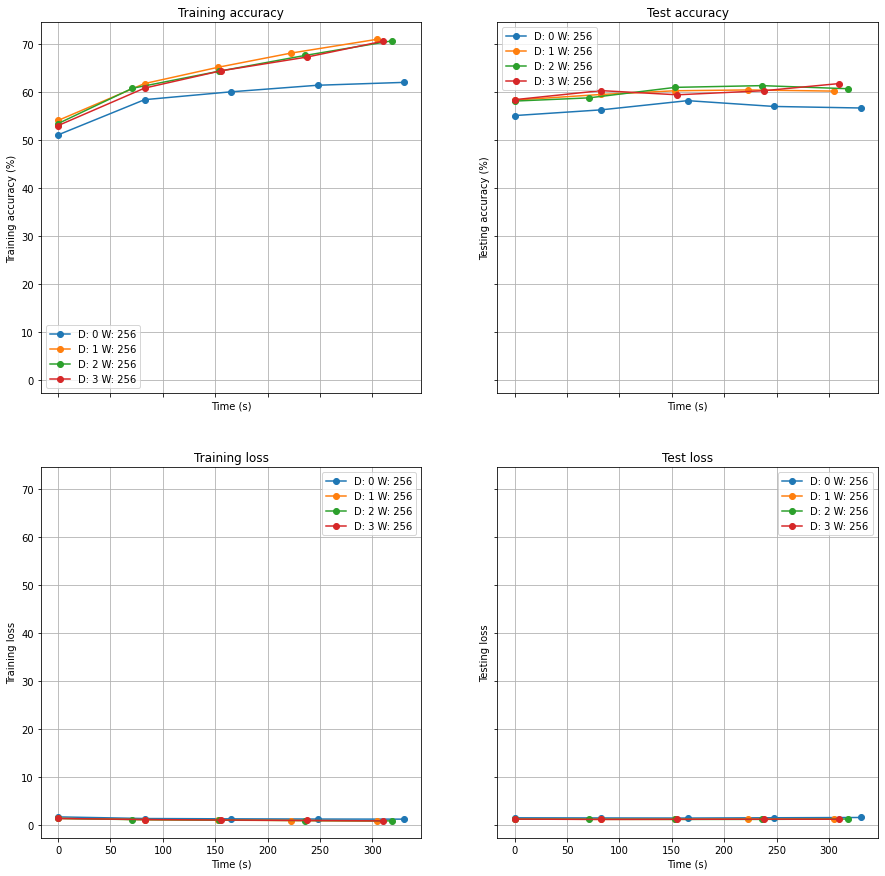

In [9]:
# Initialize by loading the dataset and creating the frozen layers
with tf.device('/device:GPU:0'):
  learning_rate = 0.00057
  training_epochs = 15
  momentum = 0.9
  batch_size = 16

  # Load CIFAR-10 dataset
  (train_images_cnn, train_labels_cnn), (test_images_cnn, test_labels_cnn) = tf.keras.datasets.cifar10.load_data()
  train_labels_cnn = tf.keras.utils.to_categorical(train_labels_cnn, num_classes=10)
  test_labels_cnn = tf.keras.utils.to_categorical(test_labels_cnn, num_classes=10)

  train_labels_cnn = train_labels_cnn.astype('float32')
  test_labels_cnn = test_labels_cnn.astype('float32')

  # Load the pre-trained ResNet model and freeze its convolutional layers
  resnet = keras.applications.ResNet101(include_top=False, weights='imagenet',
                                        input_shape=(32, 32, 3))
  for layer in resnet.layers:
      layer.trainable = False

# Trying different depths
tryTopologies(resnet, [0, 1, 2, 3], [256], train_images_cnn, train_labels_cnn,
              test_images_cnn, test_labels_cnn)

3125/3125 [==============================] - 70s 22ms/step - loss: 0.8660 - accuracy: 0.6986 - val_loss: 1.1802 - val_accuracy: 0.6147


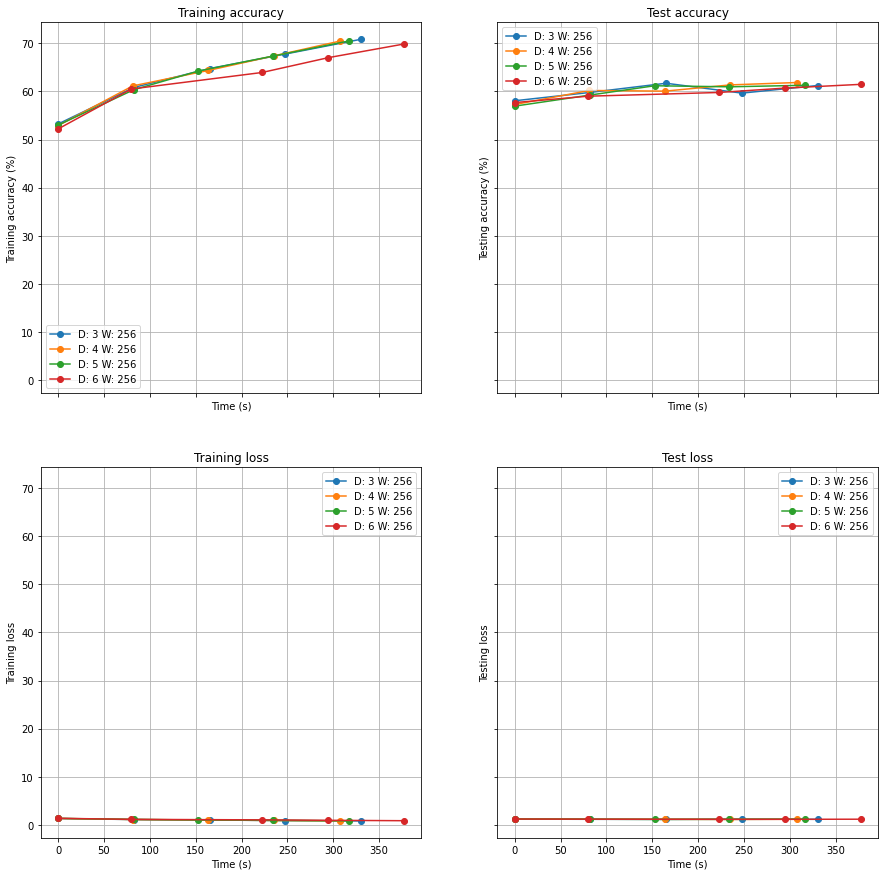

In [10]:
# Trying higher depths
tryTopologies(resnet, [3, 4, 5, 6], [256], train_images_cnn, train_labels_cnn,
              test_images_cnn, test_labels_cnn)

3125/3125 [==============================] - 75s 24ms/step - loss: 0.8059 - accuracy: 0.7190 - val_loss: 1.1949 - val_accuracy: 0.6152


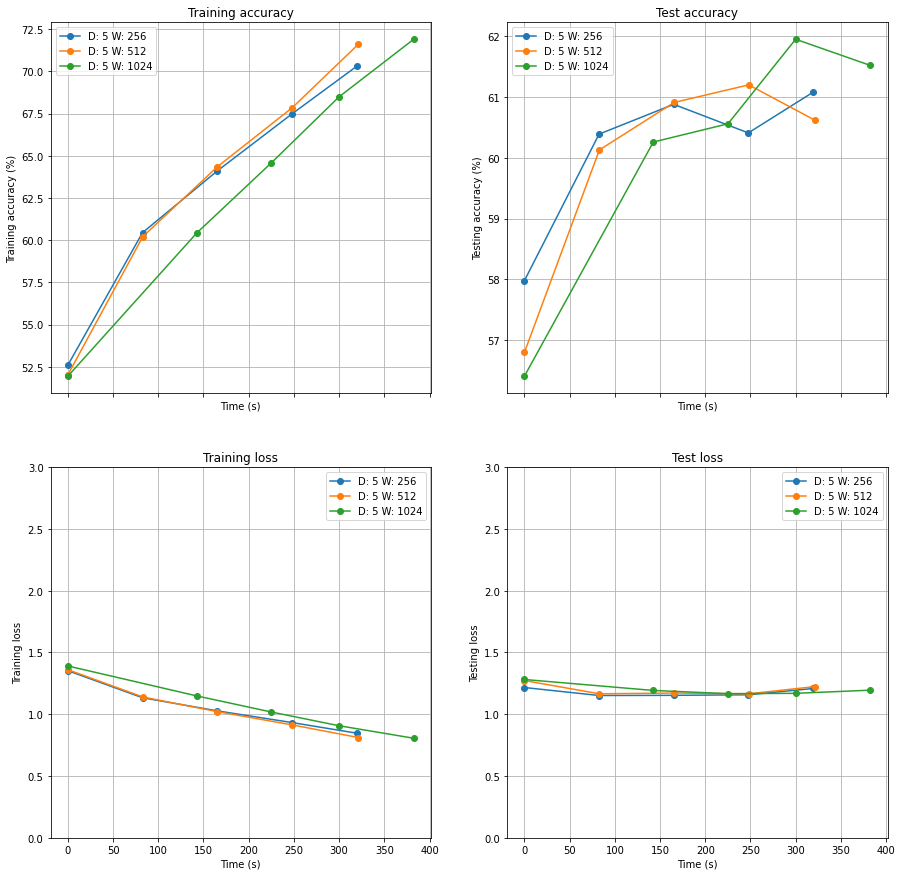

In [17]:
# Seems like there's no advantage to higher depths. What if we tried higher
# widths to go along with it?
tryTopologies(resnet, [5], [256, 512, 1024], train_images_cnn, train_labels_cnn,
              test_images_cnn, test_labels_cnn)

3125/3125 [==============================] - 71s 23ms/step - loss: 0.7629 - accuracy: 0.7288 - val_loss: 1.2457 - val_accuracy: 0.6107


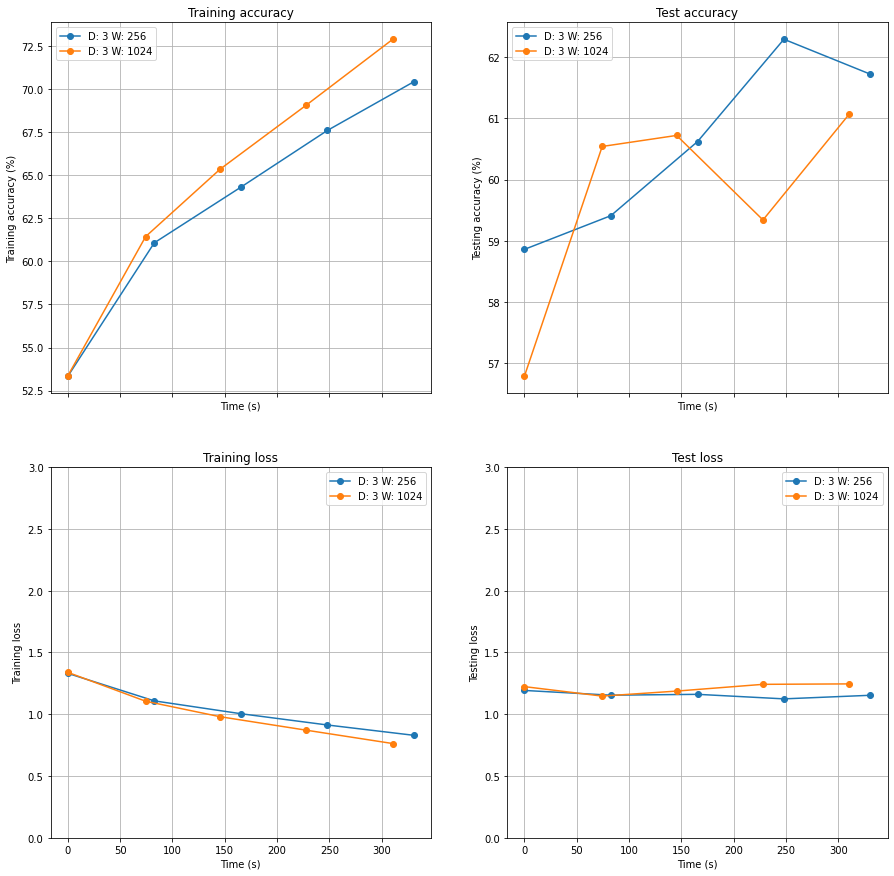

In [19]:
# D:5 performs a little bit better with 1024-wide layers. But are we just seeing
# the effects of 1024-wide nets? What happens if we move back to D:3 W:1024?
tryTopologies(resnet, [3], [256, 1024], train_images_cnn, train_labels_cnn,
              test_images_cnn, test_labels_cnn)

3125/3125 [==============================] - 69s 22ms/step - loss: 0.8254 - accuracy: 0.7061 - val_loss: 1.1811 - val_accuracy: 0.6132


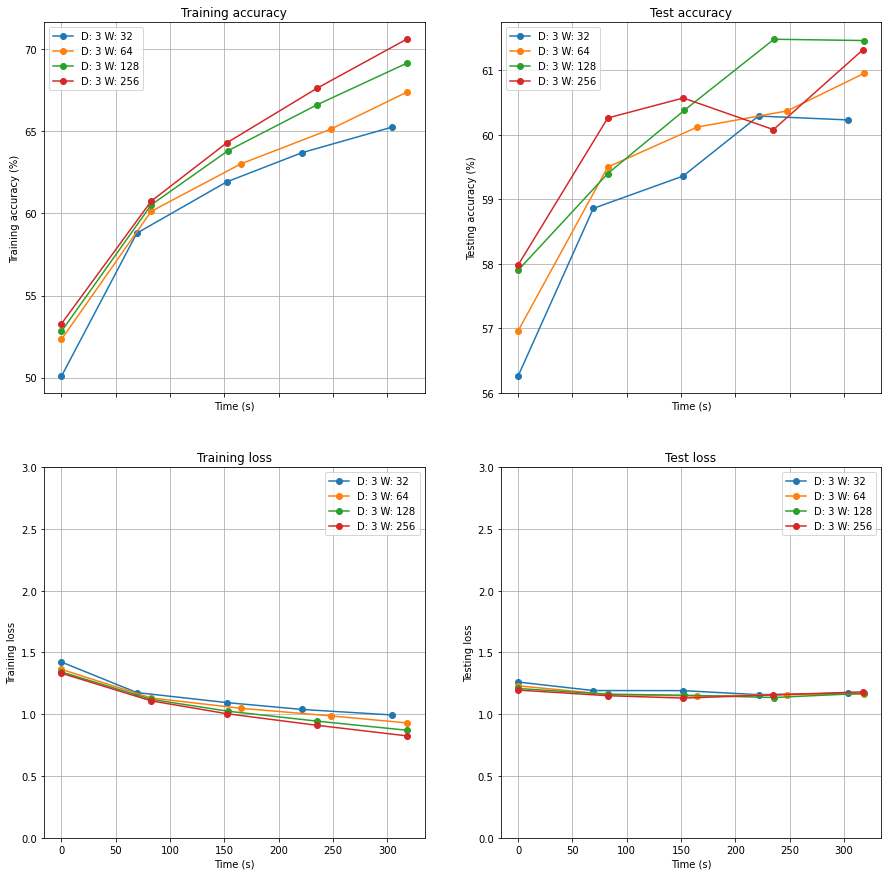

In [21]:
# D: 256 seems to be doing better. What if we go even simpler?
tryTopologies(resnet, [3], [32, 64, 128, 256], train_images_cnn, train_labels_cnn,
              test_images_cnn, test_labels_cnn)

3125/3125 [==============================] - 79s 25ms/step - loss: 1.5764 - accuracy: 0.5133 - val_loss: 1.5641 - val_accuracy: 0.5221


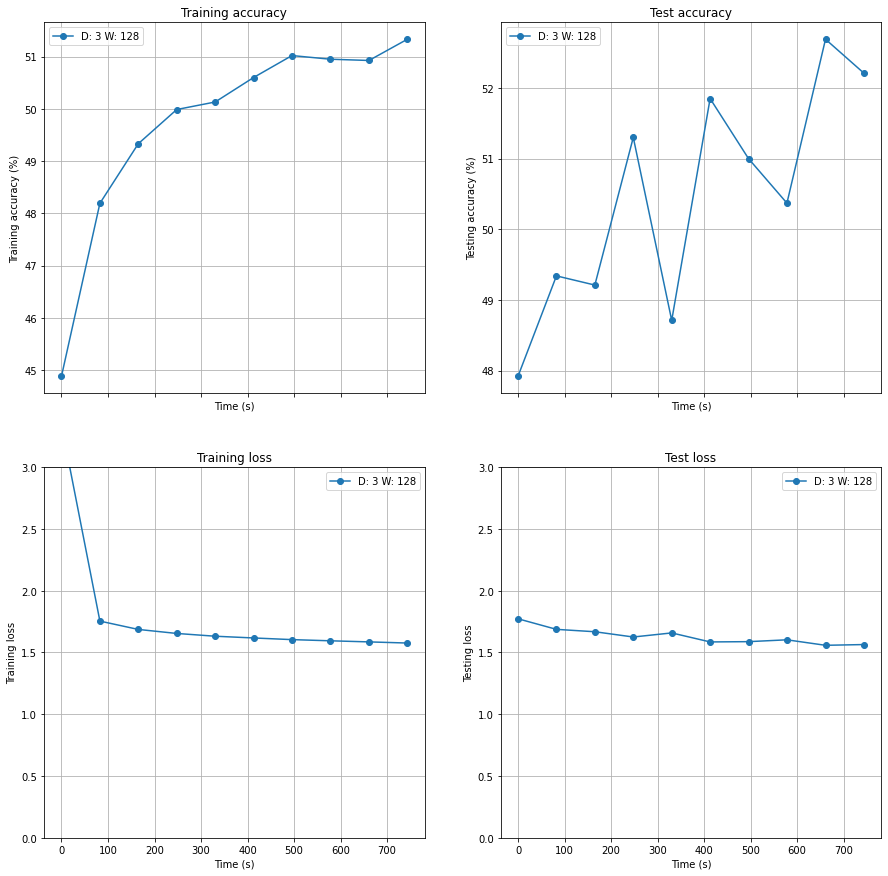

In [28]:
# D:3, W:128 seems to perform the best, but there seems to be some overfitting.
# What if there was some normalization?
tryTopologies(resnet, [3], [128], train_images_cnn, train_labels_cnn,
              test_images_cnn, test_labels_cnn, l2_norm=0.1,training_epochs=10)

3125/3125 [==============================] - 69s 22ms/step - loss: 1.3213 - accuracy: 0.5911 - val_loss: 1.3625 - val_accuracy: 0.5802


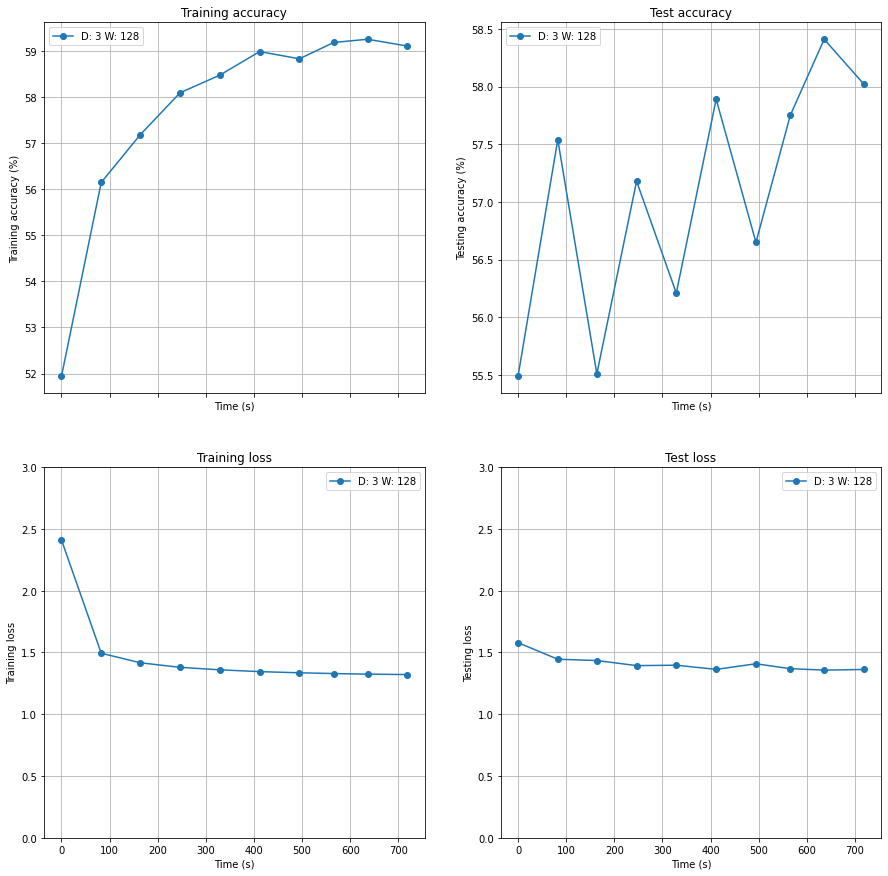

In [29]:
# Too much regularization, maybe a little less
tryTopologies(resnet, [3], [128], train_images_cnn, train_labels_cnn,
              test_images_cnn, test_labels_cnn, l2_norm=0.01,training_epochs=10)

3125/3125 [==============================] - 68s 22ms/step - loss: 0.8097 - accuracy: 0.7111 - val_loss: 1.1759 - val_accuracy: 0.6100


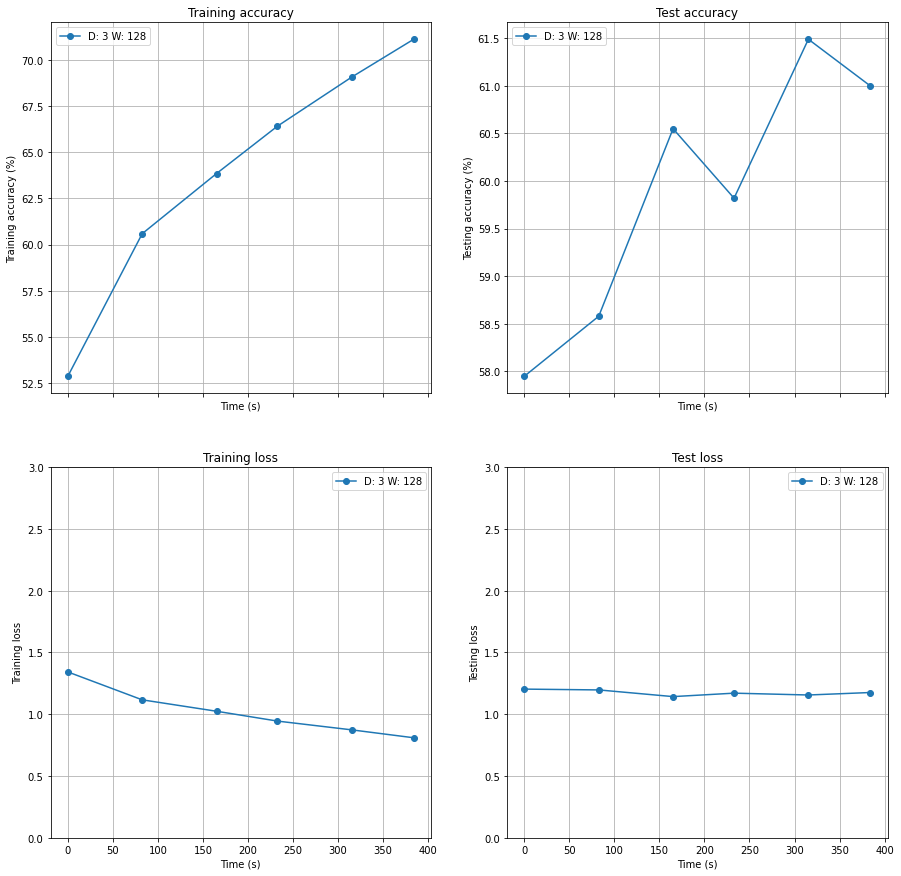

In [36]:
# Normalization leads to underfitting, now the training accuracy is
# stagnating as well. This is likely because of the fact that the network
# is already small.

# The next trial is with batch sizes. Maybe there will be a performance increase
# with smaller batches.
tryTopologies(resnet, [3], [128], train_images_cnn, train_labels_cnn,
              test_images_cnn, test_labels_cnn, training_epochs=6,
              batch_size=[8, 16])


782/782 [==============================] - 27s 34ms/step - loss: 0.9142 - accuracy: 0.6754 - val_loss: 1.1383 - val_accuracy: 0.6133


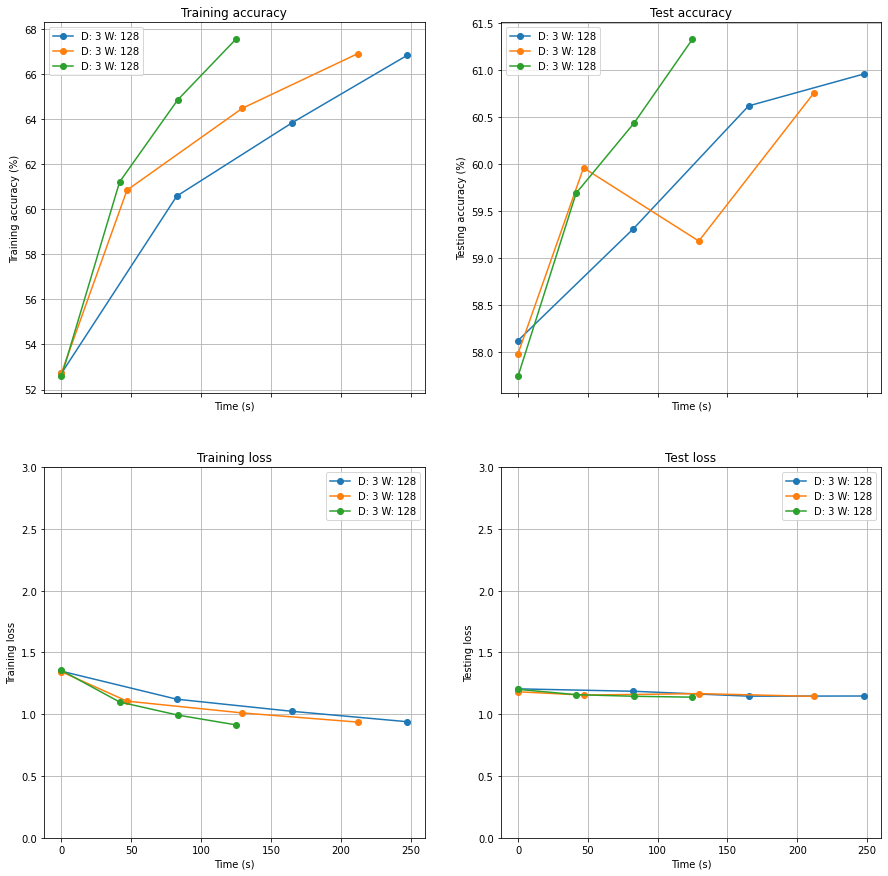

In [39]:
# That did not change much, and it is slower too. Can larger batch sizes yield
# the same results with less runtime?
tryTopologies(resnet, [3], [128], train_images_cnn, train_labels_cnn,
              test_images_cnn, test_labels_cnn, training_epochs=4,
              batch_size=[16, 32, 64])

**Ideal parameters**

*    Depth: 3
*    Width: 128
*    Batch size: 64
*    Regularization/Dropout: None

**Stats**

*   Training runtime: 125s
*   Testing accuracy: ~60-61% on most runs
